In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import yfinance as yf
import warnings
from pandas.errors import SettingWithCopyWarning
warnings.filterwarnings("ignore", category=SettingWithCopyWarning)

## 1. The (equal weighted) moving average filter of a series $X_t$ is $$\overline{X}^k_t = k^{-1}(X_t+X_{t-1}+...+X_{t-k})$$ where $k$ is the number of lags to include, sometimes called a bandwidth parameter. For daily stock prices, common values include 5, 10, 20, 50, 100, and 200. These smoothed values are often used in trading strategies of the contrarian type, that is: $$\text{buy when } X_t < \overline{X}^k_t \text{ and sell when } X_t \geq \overline{X}^k_t.$$ Download the daily S&P 500 data from the beginnig of the 2010 to the most recent trading day.

In [2]:
df = yf.download('^SPX', start='2010-01-01', end='2025-01-24', interval='1d', auto_adjust=False)
df = df.reset_index()
df.columns = df.columns.droplevel(1)
df = df[['Date', 'Adj Close']]
df.head()

[*********************100%***********************]  1 of 1 completed


Price,Date,Adj Close
0,2010-01-04,1132.989990
1,2010-01-05,1136.520020
2,2010-01-06,1137.140015
3,2010-01-07,1141.689941
4,2010-01-08,1144.979980


### (a) Compute the moving average filters of the adjusted closing prices for $k \in$ {5, 10, 20, 50, 100, 200}. Plot the moving average filters for $k \in$ {5, 10, 20, 50, 100, 200} alongside the adjusted closing prices from the beginning of 2023.

In [3]:
# Different moving averages
k = [5, 10, 20, 50, 100, 200]
k_ = [5, 20, 50, 200]
ma = pd.DataFrame()

# Loop through moving averages and add a column for each MA
for i in k:
    ma[f'MA_{i}'] = df['Adj Close'].rolling(window=i).mean()

ma['Date'] = df['Date']
ma['Date'] = pd.to_datetime(ma['Date'])
ma.head() # Shows NaN's because the rolling takes the past i days

,MA_5,MA_10,MA_20,MA_50,MA_100,MA_200,Date
0,NaN,NaN,NaN,NaN,NaN,NaN,2010-01-04
1,NaN,NaN,NaN,NaN,NaN,NaN,2010-01-05
2,NaN,NaN,NaN,NaN,NaN,NaN,2010-01-06
3,NaN,NaN,NaN,NaN,NaN,NaN,2010-01-07
4,1138.663989,NaN,NaN,NaN,NaN,NaN,2010-01-08


In [4]:
ma_recent = ma[ma['Date'] >= '2023-01-01']
df_recent = df[df['Date'] >= '2023-01-01']

[]

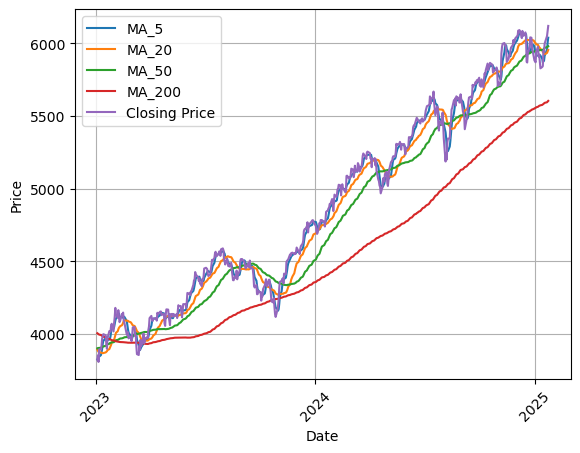

In [5]:
# Plot different moving averages
for i in k_:
    plt.plot(ma_recent['Date'], ma_recent[f'MA_{i}'], label = f'MA_{i}')

plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.plot(ma_recent['Date'], df_recent['Adj Close'], label = 'Closing Price')
plt.xticks(rotation  = 45)
plt.grid()
plt.legend()
plt.ylabel('Price')
plt.xlabel('Date')
plt.plot()

### (b) Implement daily contrarian trading strategies using the moving average filters from part (a). Estimate the expected daily log returns and Sharpe ratios for these strategies.

In [6]:
# Add moving averages to df
for i in k:
    df_recent[f'MA_{i}'] = ma[f'MA_{i}']

# Add buy conditions to df for contrarian strategies
for i in k:
    df_recent[f'buy_{i}'] = np.where(df_recent['Adj Close'] < df_recent[f'MA_{i}'], 1, 0)

df_recent.head()

Price,Date,Adj Close,MA_5,MA_10,MA_20,MA_50,MA_100,MA_200,buy_5,buy_10,buy_20,buy_50,buy_100,buy_200
3272,2023-01-03,3824.139893,3825.077979,3831.031982,3891.793494,3901.430815,3898.714617,4005.438265,1,1,1,1,1,1
3273,2023-01-04,3852.969971,3829.821973,3834.562988,3884.499988,3903.435215,3895.171616,4002.387515,0,0,1,1,1,1
3274,2023-01-05,3808.100098,3834.797998,3833.210986,3877.841992,3903.650415,3890.451118,3999.122114,1,1,1,1,1,1
3275,2023-01-06,3895.080078,3843.958008,3834.875000,3875.900000,3904.369814,3886.430518,3996.039465,0,0,0,1,0,1
3276,2023-01-09,3892.090088,3854.476025,3841.845020,3872.329004,3905.599614,3882.299417,3993.218715,0,0,0,1,0,1


In [7]:
# create log_returns and sharpe ratio dataframe for contrarian trading strategy
log_returns_c = pd.DataFrame()
sr_c = pd.DataFrame()

# Daily log returns for each moving average
for i in k:
    log_returns_c[f'returns_{i}'] = np.where(
        df_recent[f'buy_{i}'] == 1, np.log(df_recent['Adj Close'] / df_recent['Adj Close'].shift(1)), 0)

# Daily sharpe ratio for each moving average
for i in k:
    sr_c[f'sr_{i}'] = np.where(
        df_recent[f'buy_{i}'] == 1, log_returns_c[f'returns_{i}']/log_returns_c[f'returns_{i}'].std(), 0)

print(log_returns_c.head())
print(sr_c.head())

   returns_5  returns_10  returns_20  returns_50  returns_100  returns_200
0        NaN         NaN         NaN         NaN          NaN          NaN
1   0.000000    0.000000    0.007511    0.007511     0.007511     0.007511
2  -0.011714   -0.011714   -0.011714   -0.011714    -0.011714    -0.011714
3   0.000000    0.000000    0.000000    0.022584     0.000000     0.022584
4   0.000000    0.000000    0.000000   -0.000768     0.000000    -0.000768
       sr_5     sr_10     sr_20     sr_50    sr_100    sr_200
0       NaN       NaN       NaN       NaN       NaN       NaN
1  0.000000  0.000000  1.417672  1.477976  2.295734  3.077860
2 -2.242131 -2.202256 -2.211037 -2.305088 -3.580485 -4.800308
3  0.000000  0.000000  0.000000  4.444111  0.000000  9.254787
4  0.000000  0.000000  0.000000 -0.151115  0.000000 -0.314694


### (c) Conduct the same analysis as in part (b) for daily momentum trading strategies.

In [8]:
# Add buy conditions to df for momentum strategies
for i in k:
    df_recent[f'buy_{i}'] = np.where(df_recent['Adj Close'] >= df_recent[f'MA_{i}'], 1, 0)

df_recent.head()

Price,Date,Adj Close,MA_5,MA_10,MA_20,MA_50,MA_100,MA_200,buy_5,buy_10,buy_20,buy_50,buy_100,buy_200
3272,2023-01-03,3824.139893,3825.077979,3831.031982,3891.793494,3901.430815,3898.714617,4005.438265,0,0,0,0,0,0
3273,2023-01-04,3852.969971,3829.821973,3834.562988,3884.499988,3903.435215,3895.171616,4002.387515,1,1,0,0,0,0
3274,2023-01-05,3808.100098,3834.797998,3833.210986,3877.841992,3903.650415,3890.451118,3999.122114,0,0,0,0,0,0
3275,2023-01-06,3895.080078,3843.958008,3834.875000,3875.900000,3904.369814,3886.430518,3996.039465,1,1,1,0,1,0
3276,2023-01-09,3892.090088,3854.476025,3841.845020,3872.329004,3905.599614,3882.299417,3993.218715,1,1,1,0,1,0


In [9]:
# create log_returns and sharpe ratio dataframe for momentum trading strategy
log_returns_m = pd.DataFrame()
sr_m = pd.DataFrame()

# Daily log returns for each moving average
for i in k:
    log_returns_m[f'returns_{i}'] = np.where(
        df_recent[f'buy_{i}'] == 1, np.log(df_recent['Adj Close'] / df_recent['Adj Close'].shift(1)), 0)

# Daily sharpe ratio for each moving average
for i in k:
    sr_m[f'sr_{i}'] = np.where(
        df_recent[f'buy_{i}'] == 1, log_returns_m[f'returns_{i}']/log_returns_m[f'returns_{i}'].std(), 0)

print(log_returns_m.head())
print(sr_m.head())

   returns_5  returns_10  returns_20  returns_50  returns_100  returns_200
0   0.000000    0.000000    0.000000         0.0     0.000000          0.0
1   0.007511    0.007511    0.000000         0.0     0.000000          0.0
2   0.000000    0.000000    0.000000         0.0     0.000000          0.0
3   0.022584    0.022584    0.022584         0.0     0.022584          0.0
4  -0.000768   -0.000768   -0.000768         0.0    -0.000768          0.0
       sr_5     sr_10     sr_20  sr_50    sr_100  sr_200
0  0.000000  0.000000  0.000000    0.0  0.000000     0.0
1  1.434479  1.354067  0.000000    0.0  0.000000     0.0
2  0.000000  0.000000  0.000000    0.0  0.000000     0.0
3  4.313320  4.071531  3.779218    0.0  3.048603     0.0
4 -0.146668 -0.138446 -0.128506    0.0 -0.103663     0.0


### (d) Based on your findings in parts (b) and (c), which trading strategy do you prefer? Justify your choice.

#### Under Contrarian Strategy:

In [10]:
for i in k:
    print(f'k = {i}')
    print(log_returns_c[f'returns_{i}'].mean())

k = 5
-0.0019617576369316413
k = 10
-0.0014595359703922298
k = 20
-0.0006872331893421401
k = 50
-0.0003565567798692975
k = 100
-0.00016668675144260818
k = 200
-6.940838620777625e-05


#### Under Momentum Strategy:

In [11]:
for i in k:
    print(f'k = {i}')
    print(log_returns_m[f'returns_{i}'].mean())

k = 5
0.0028688428087613803
k = 10
0.0023675944400253397
k = 20
0.0015967883697912387
k = 50
0.0012667528060731883
k = 100
0.0010772507428178685
k = 200
0.0009801609015466699


Based on my results from (b) and (c), I prefer the momentum trading strategy because the average return is positive for all values of $k$, while the contrarian strategy yields negative returns. This suggests momentum is consistently more profitable and sustainable.

## 2. The so-called Bollinger bands are a modification of the moving average rules that allow a margin of safety by allowing for time varying volatility. They are defined as follows $$BB^U_t = \overline{X}^k_t + 2 \sigma_t,$$ $$BB^L_t = \overline{X}^k_t - 2\sigma_t,$$ where $\sigma_t$ denotes the sample standard deviation of {$X_t, X_{t-1}, ..., X_{t-k}$}. Compute the Bollinger bands for your data series and compare the contrarian type trading strategies:

## buy when $X_t < BB^L_t$, sell when $X_t \geq BB^U_t$ and do nothing otherwise

## or moment type, that is

## buy when $X_t \geq BB^U_t$, selle when $X_t < BB^L_t$ and do nothing otherwise. 

## Use daily S&P 500 data from the beginning of 2010 to the most recent trading day.

### (a) Compute the Bollinger bands of the adjusted closing prices for $k \in$ {5, 10, 20, 50, 100, 200}. Plot the Bollinger bands for $k \in$ {5, 20} alongside the adjusted closing prices from the beginning of 2023.

In [12]:
sigma = pd.DataFrame()
bb = pd.DataFrame()

for i in k:
    sigma[f'sigma_{i}'] = df['Adj Close'].rolling(window=i).std()

for i in k:
    bb[f'bbu_{i}'] = ma[f'MA_{i}'] + 2*sigma[f'sigma_{i}']
    bb[f'bbl_{i}'] = ma[f'MA_{i}'] - 2*sigma[f'sigma_{i}']

bb['Date'] = ma['Date']
bb_recent = bb[bb['Date'] >= '2023-01-01']
bb_recent.head()

,bbu_5,bbl_5,bbu_10,bbl_10,bbu_20,bbl_20,bbu_50,bbl_50,bbu_100,bbl_100,bbu_200,bbl_200,Date
3272,3875.715045,3774.440912,3880.567920,3781.496045,4039.383666,3744.203321,4090.872380,3711.989251,4246.015991,3551.413242,4492.038460,3518.838071,2023-01-03
3273,3886.497740,3773.146205,3884.890156,3784.235821,4024.012650,3744.987326,4088.526674,3718.343756,4236.939593,3553.403640,4485.087314,3519.687716,2023-01-04
3274,3872.059664,3797.536332,3885.760819,3780.661154,4018.652902,3737.031082,4088.262791,3719.038039,4223.667902,3557.234335,4478.167005,3520.077224,2023-01-05
3275,3910.238494,3777.677522,3894.383273,3775.366727,4014.508593,3737.291407,4088.553600,3720.186029,4209.364430,3563.496605,4469.731473,3522.347458,2023-01-06
3276,3932.813645,3776.138406,3910.481435,3773.208604,4004.986211,3739.671797,4088.590217,3722.609012,4193.961212,3570.637621,4462.593135,3523.844294,2023-01-09


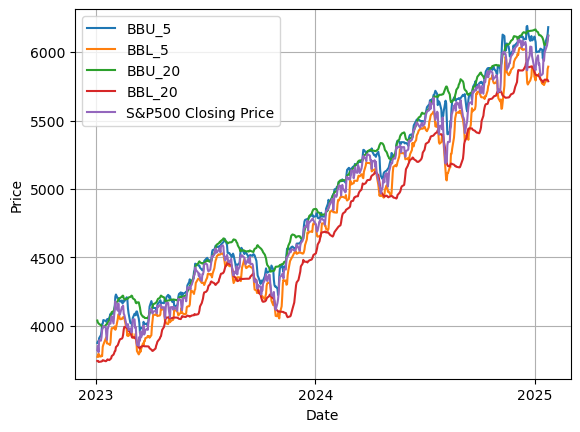

In [13]:
k_2 = [5, 20]

for i in k_2:
    plt.plot(bb_recent['Date'], bb_recent[f'bbu_{i}'], label = f'BBU_{i}')
    plt.plot(bb_recent['Date'], bb_recent[f'bbl_{i}'], label = f'BBL_{i}')

plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.plot(bb_recent['Date'], df_recent['Adj Close'], label = 'S&P500 Closing Price')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid()
plt.show()

### (b) Implement daily contrarian trading strategies using the Bollinger bands from part (a). Estimate the expected daily log returns and Sharpe ratios for these strategies.

In [27]:
df_recent = df[df['Date'] >= '2023-01-01']

# Add buy conditions to df for contrarian strategies
for i in k_2:
    df_recent[f'buy_{i}'] = np.where(df_recent['Adj Close'] < bb_recent[f'bbl_{i}'], 1, 0)

print('Buy with 5 day moving average', df_recent['buy_5'].sum(), 'times')
print('Buy with 20 day moving average', df_recent['buy_20'].sum(), 'times')

Buy with 5 day moving average 0 times
Buy with 20 day moving average 19 times


In [15]:
# create log_returns and sharpe ratio dataframe for contrarian trading strategy
log_returns_c = pd.DataFrame()
sr_c = pd.DataFrame()

# Daily log returns for 20 day moving average
log_returns_c['returns_20'] = np.where(
    df_recent['buy_20'] == 1, np.log(df_recent['Adj Close'] / df_recent['Adj Close'].shift(1)), 0)

# Daily sharpe ratio for each moving average
sr_c['sr_20'] = np.where(
    df_recent['buy_20'] == 1, log_returns_c['returns_20'] / log_returns_c['returns_20'].std(), 0)

In [30]:
print('Mean log return =', log_returns_c['returns_20'].mean())
print('Mean Sharpe ratio =', sr_c['sr_20'].mean())

Mean log return = -0.00041664921384479317
Mean Sharpe ratio = -0.15507688102044423


For the contrarian Bollinger bands strategy, the expected daily log return is negative and close to zero for the 20 day moving average, and the expected Sharpe ratio for the 20 moving average is also negative. Meaningful buy signals only occurred when the rolling window was set to $k = 20$, which severely limits the number of trades.

### (c) Conduct the same analysis as in part (b) for daily momentum trading strategies.

In [28]:
# Add buy conditions to df for momentum strategies
for i in k_2:
    df_recent[f'buy_{i}'] = np.where(df_recent['Adj Close'] >= bb_recent[f'bbu_{i}'], 1, 0)

print('Buy with 5 day moving average', df_recent['buy_5'].sum(), 'times')
print('Buy with 20 day moving average', df_recent['buy_20'].sum(), 'times')

Buy with 5 day moving average 0 times
Buy with 20 day moving average 30 times


Once again, you only buy when the rolling window is 20.

In [32]:
# create log_returns and sharpe ratio dataframe for momentum trading strategy
log_returns_m = pd.DataFrame()
sr_m = pd.DataFrame()

# Daily log returns for 20 day moving average
log_returns_m['returns_20'] = np.where(
    df_recent['buy_20'] == 1, np.log(df_recent['Adj Close'] / df_recent['Adj Close'].shift(1)), 0)

# Daily sharpe ratio for each moving average
sr_m['sr_20'] = np.where(
    df_recent['buy_20'] == 1, log_returns_m['returns_20'] / log_returns_c['returns_20'].std(), 0)

In [33]:
print('Mean log return =', log_returns_m['returns_20'].mean())
print('Mean Sharpe ratio =', sr_m['sr_20'].mean())

Mean log return = 0.00046217081018455955
Mean Sharpe ratio = 0.1720200239446796


For the momentum Bollinger bands strategy, the expected daily log return is positive and close to zero for the 20 day moving average, and the expected Sharpe ratio for the 20 moving average is also positive at around 0.17. Once again, meaningful buy signals only occurred when the rolling window was set to $k = 20$, still limiting the number of trades.

### (d) Based on your findings in parts (b) and (c) of Question 1, as well as parts (b) and (c) of this question, which trading strategy do you prefer? Provide a justification for your choice.

Based on these trading strategies, I would still prefer the momentum trading strategy using moving averages because it produces the highest average returns for all values of k. In contrast, the Bollinger Bands strategy only generates buy opportunities when k equals 20, making it less flexible and less reliable in practice. The contrarian strategy produces negative returns in both Question 1, and when using Bollinger bands.